# Comparing embeddings from BERT and ModernBERT

### Setup

In [220]:
import pandas as pd 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sea
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


pd.options.display.max_rows = 999
pd.set_option('max_colwidth', 1000)

### Data Acess

In [222]:
# lendo o dado processado no notebook Datasets/data_treatment.ipynb
dataframe = pd.read_parquet('../Datasets/pre_processed_dataframes/embeddings_df.parquet')
print(len(dataframe))
dataframe = dataframe[dataframe['language_name'] == 'English'].copy()
print(len(dataframe))
dataframe = dataframe.rename(columns={'m_bert_embeddings_ull_description': 'm_bert_embeddings_full_description'})
cols = []
cols.append('description')
cols.append('title')
cols.append('Category')


5070
2952


In [223]:
dataframe[cols].sample()

,description,title,Category
327,"GaadiWaadi - Here, we have listed the seven most highly-anticipated seven-seater SUVs and MPVs that will be launching in the Indian market within a year For the automobile industry, 2020 was an extremely challenging year, and 2021 turned out to be only slightly better. However, the Indian market is expected to see a major recovery in the […] The post Upcoming 7-Seater Cars Launching In India In Next 12-18 Months appeared first on Gaadiwaadi.com - Latest Car & Bike News by Kshitij Rawat.",Upcoming 7-Seater Cars Launching In India In Next 12-18 Months,Latest


### TSNE

In [233]:
bert_embeddings = dataframe['embeddings_full_description']
m_bert_embeddings = dataframe['m_bert_embeddings_full_description']

bert_embeddings = np.vstack(bert_embeddings)
m_bert_embeddings = np.vstack(m_bert_embeddings)

Gerando visualização com t-SNE...


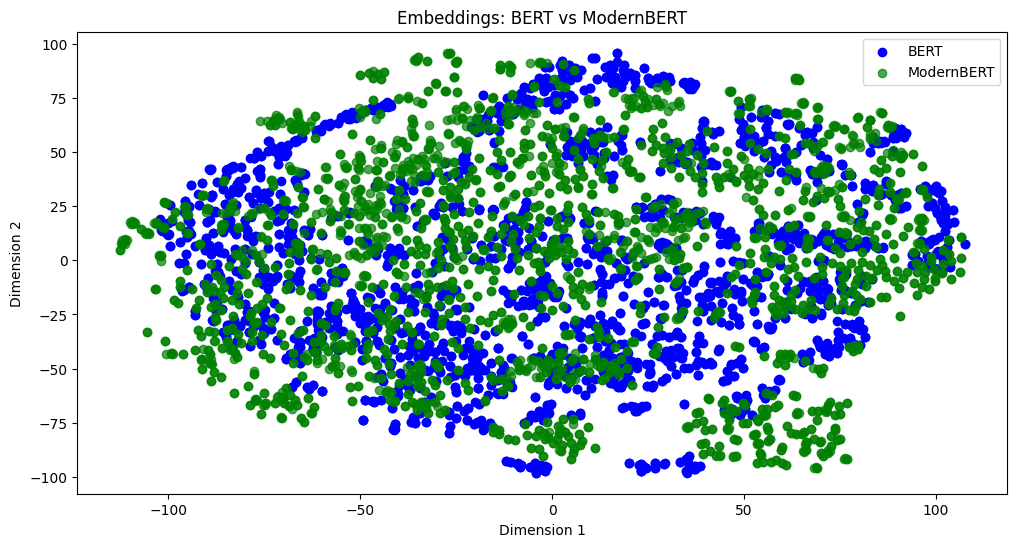

In [234]:
print("Gerando visualização com t-SNE...")
tsne_model1 = TSNE(n_components=2, 
                   metric='cosine',
                   perplexity=15,
                   early_exaggeration=2,
                   random_state=42).fit_transform(bert_embeddings)

tsne_model2 = TSNE(n_components=2, 
                   metric='cosine',
                   perplexity=15,
                   early_exaggeration=2,
                   random_state=42).fit_transform(m_bert_embeddings)

y = dataframe['Category']
plt.figure(figsize=(12, 6))
plt.scatter(tsne_model1[:, 0], tsne_model1[:, 1], color='blue', label="BERT")
plt.scatter(tsne_model2[:, 0], tsne_model2[:, 1], color='green', label="ModernBERT", alpha=0.7)
plt.title("Embeddings: BERT vs ModernBERT")
plt.legend()
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

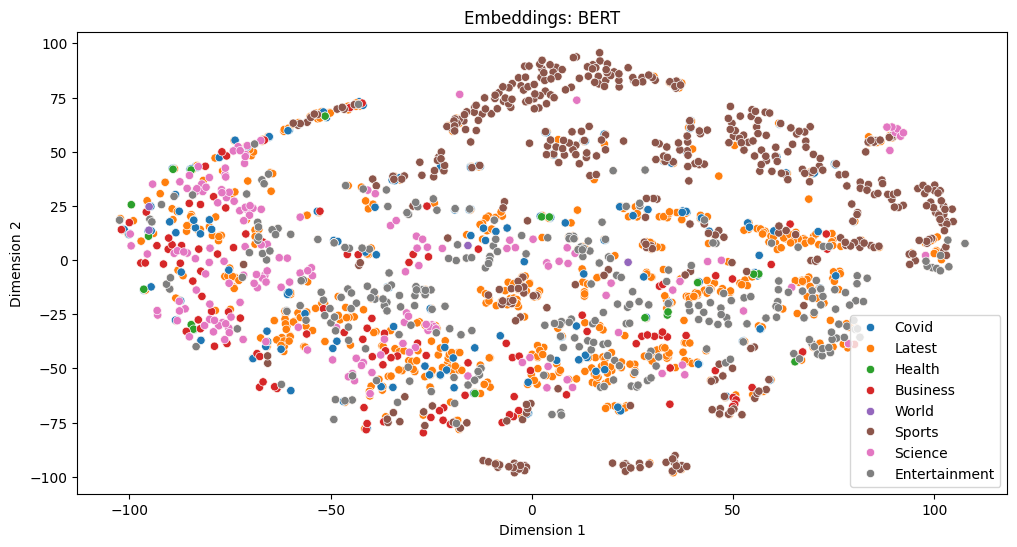

In [236]:
y = dataframe['Category']
plt.figure(figsize=(12, 6))
sea.scatterplot(x=tsne_model1[:, 0], y=tsne_model1[:, 1], hue=y)
plt.title("Embeddings: BERT")
plt.legend()
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

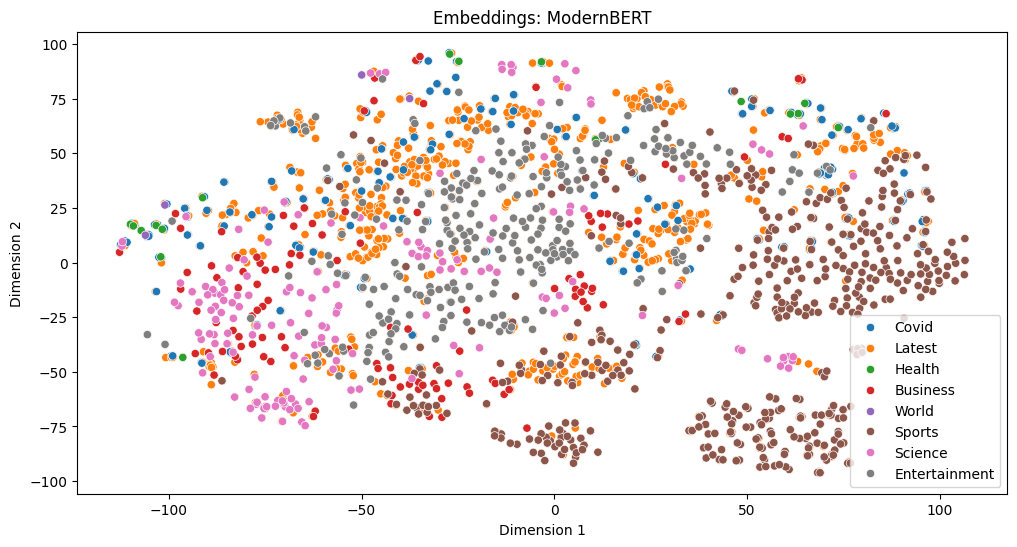

In [237]:
y = dataframe['Category'] 
plt.figure(figsize=(12, 6))
sea.scatterplot(x=tsne_model2[:, 0], y=tsne_model2[:, 1], hue=y)
plt.title("Embeddings: ModernBERT")
plt.legend()
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

## KMeans

In [238]:
n_clusters_range = 10
for cluster in np.arange(3, n_clusters_range, step=1):
    kmeans1 = KMeans(n_clusters=cluster, random_state=42).fit(bert_embeddings)
    kmeans2 = KMeans(n_clusters=cluster, random_state=42).fit(m_bert_embeddings)
    sil1 = silhouette_score(bert_embeddings, kmeans1.labels_)
    sil2 = silhouette_score(m_bert_embeddings, kmeans2.labels_)
    print(f'Cluster = {cluster}')
    print(f"Silhouette Score - BERT: {sil1}, ModernBERT: {sil2}")



Cluster = 3
Silhouette Score - BERT: 0.4333623945713043, ModernBERT: 0.16086454689502716
Cluster = 4
Silhouette Score - BERT: 0.3813619315624237, ModernBERT: 0.12647981941699982
Cluster = 5
Silhouette Score - BERT: 0.2914199233055115, ModernBERT: 0.1033969447016716
Cluster = 6
Silhouette Score - BERT: 0.2689785957336426, ModernBERT: 0.09177011996507645
Cluster = 7
Silhouette Score - BERT: 0.2657811939716339, ModernBERT: 0.0801435112953186
Cluster = 8
Silhouette Score - BERT: 0.2073727399110794, ModernBERT: 0.08232417702674866
Cluster = 9
Silhouette Score - BERT: 0.180297389626503, ModernBERT: 0.07940907031297684


## Similarity

In [239]:
sim_bert= cosine_similarity(bert_embeddings)
sim_mbert = cosine_similarity(m_bert_embeddings)
diff_similarities = np.abs(sim_bert - sim_mbert)
mean_sim_bert = np.round(sim_bert.mean(), 3)
mean_sim_mbert = np.round(sim_mbert.mean(), 3)

print(f"Mean Similarity: BERT = {mean_sim_bert:.3f}, ModernBERT = {mean_sim_mbert:.3f}")

Mean Similarity: BERT = 0.942, ModernBERT = 0.900


In [240]:
categories = dataframe['Category'].unique()

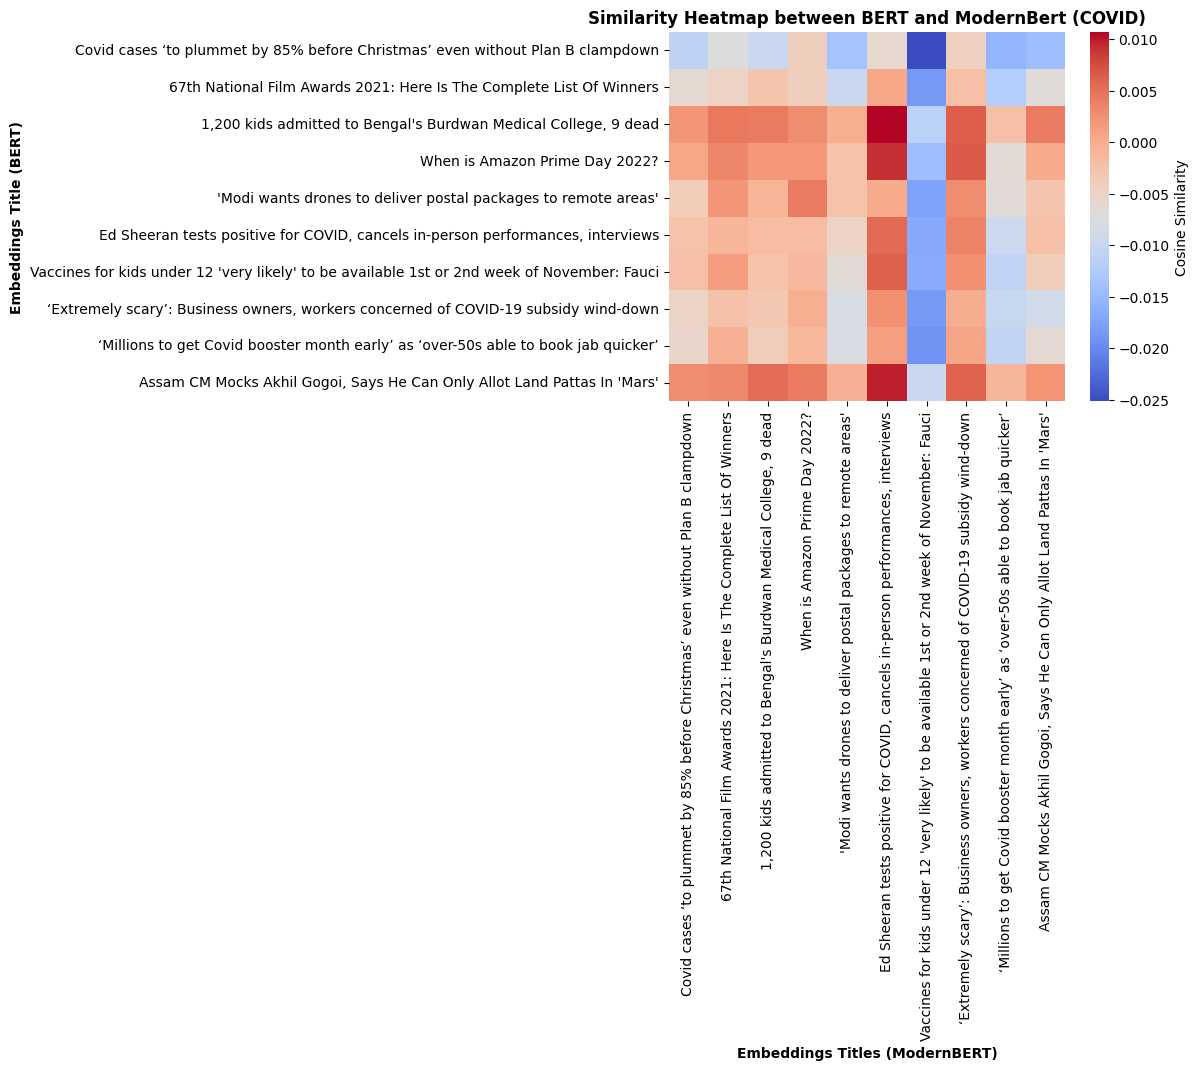

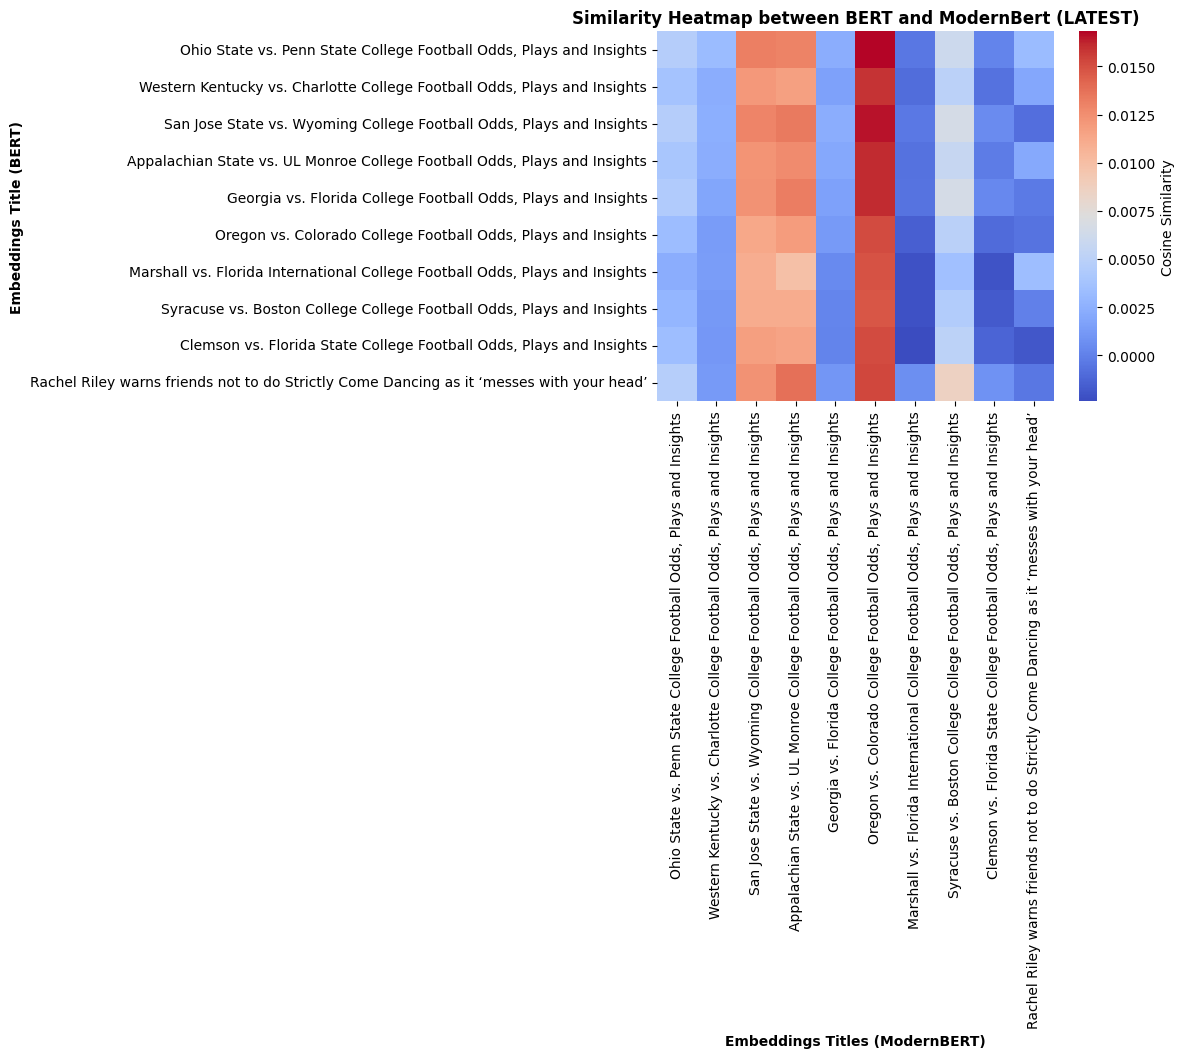

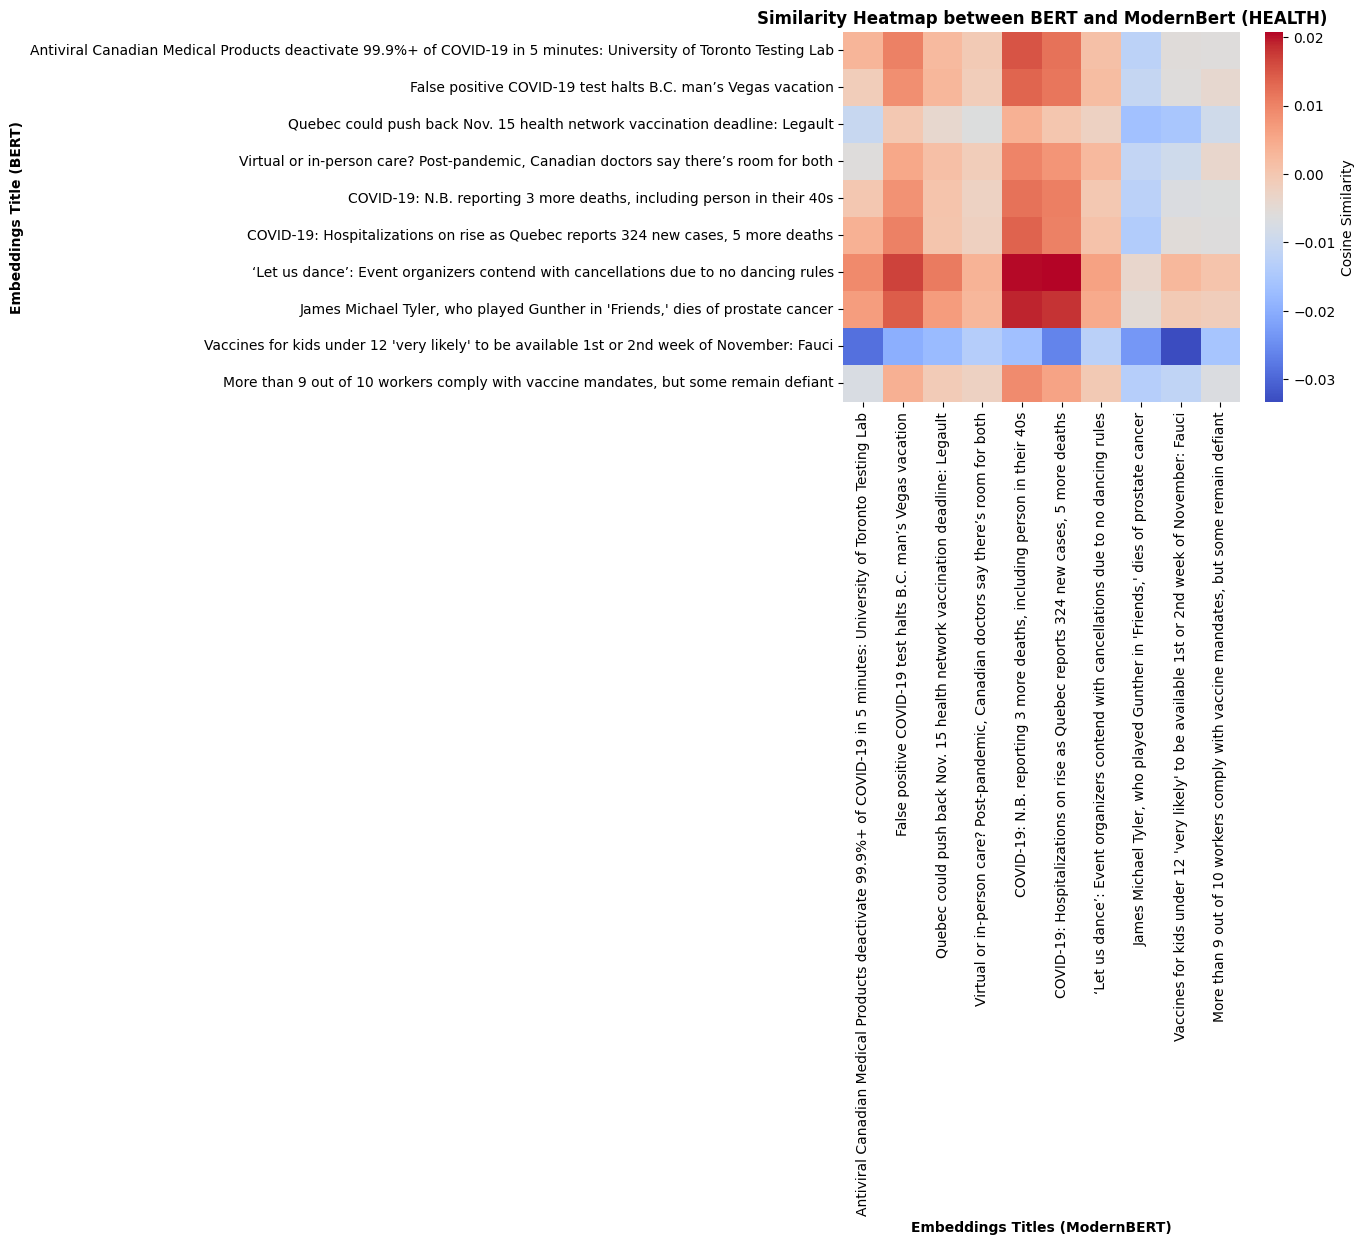

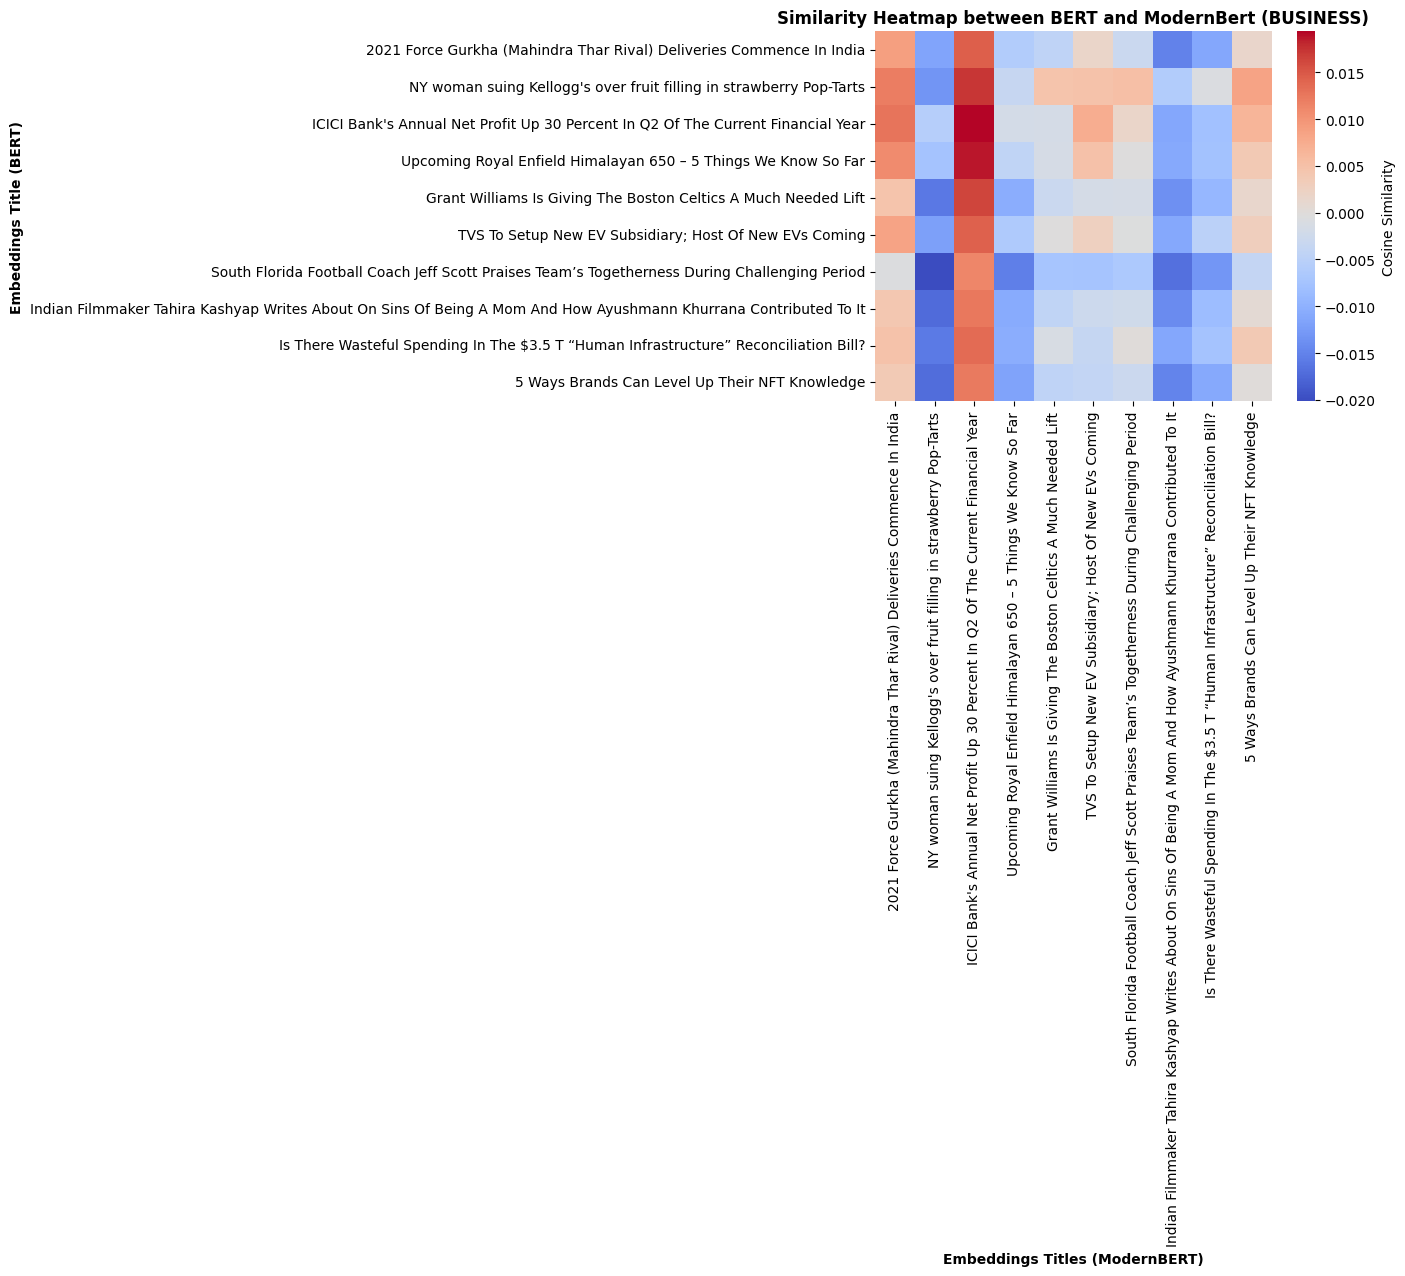

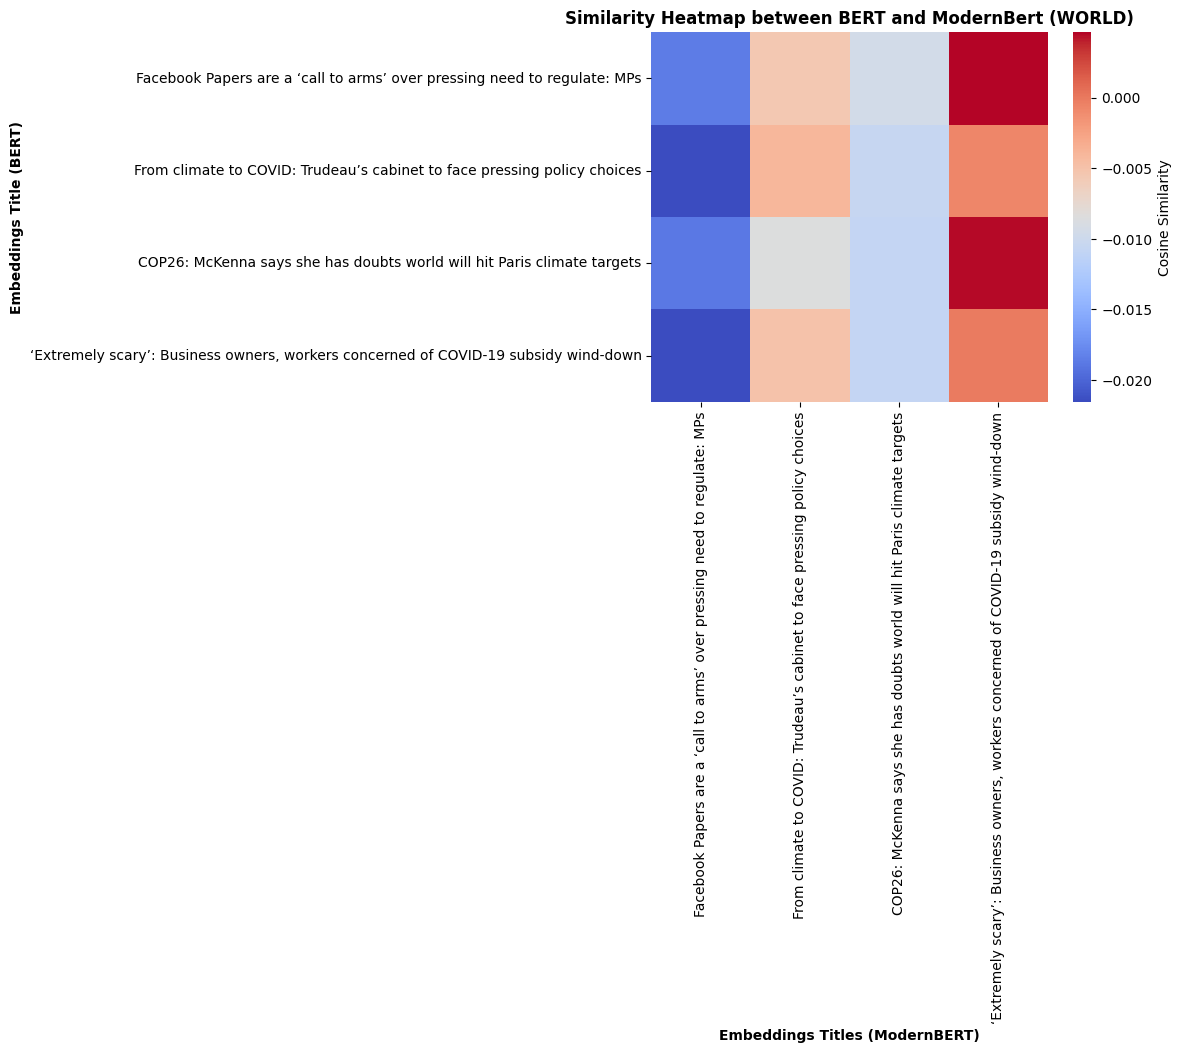

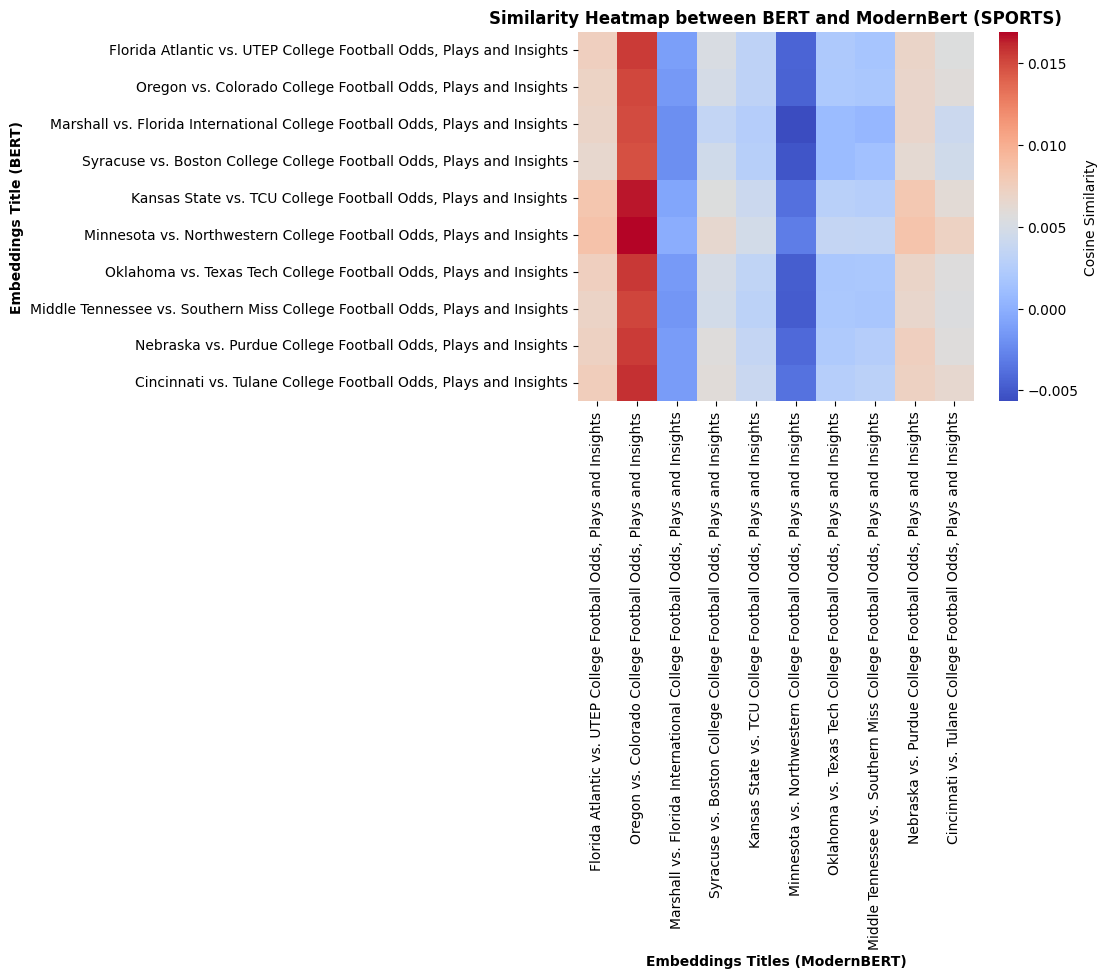

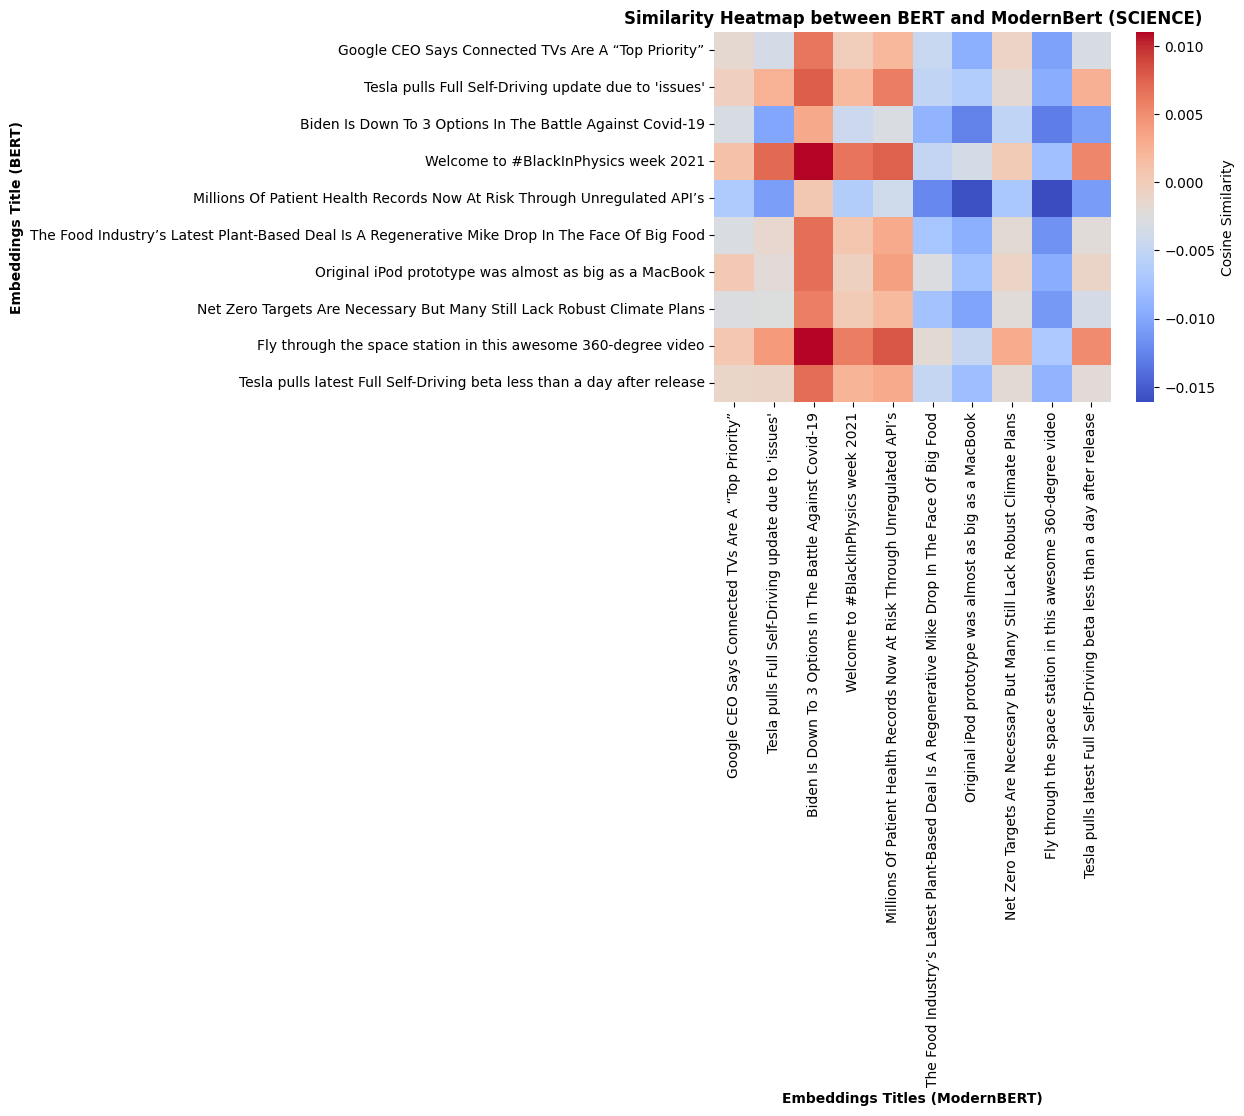

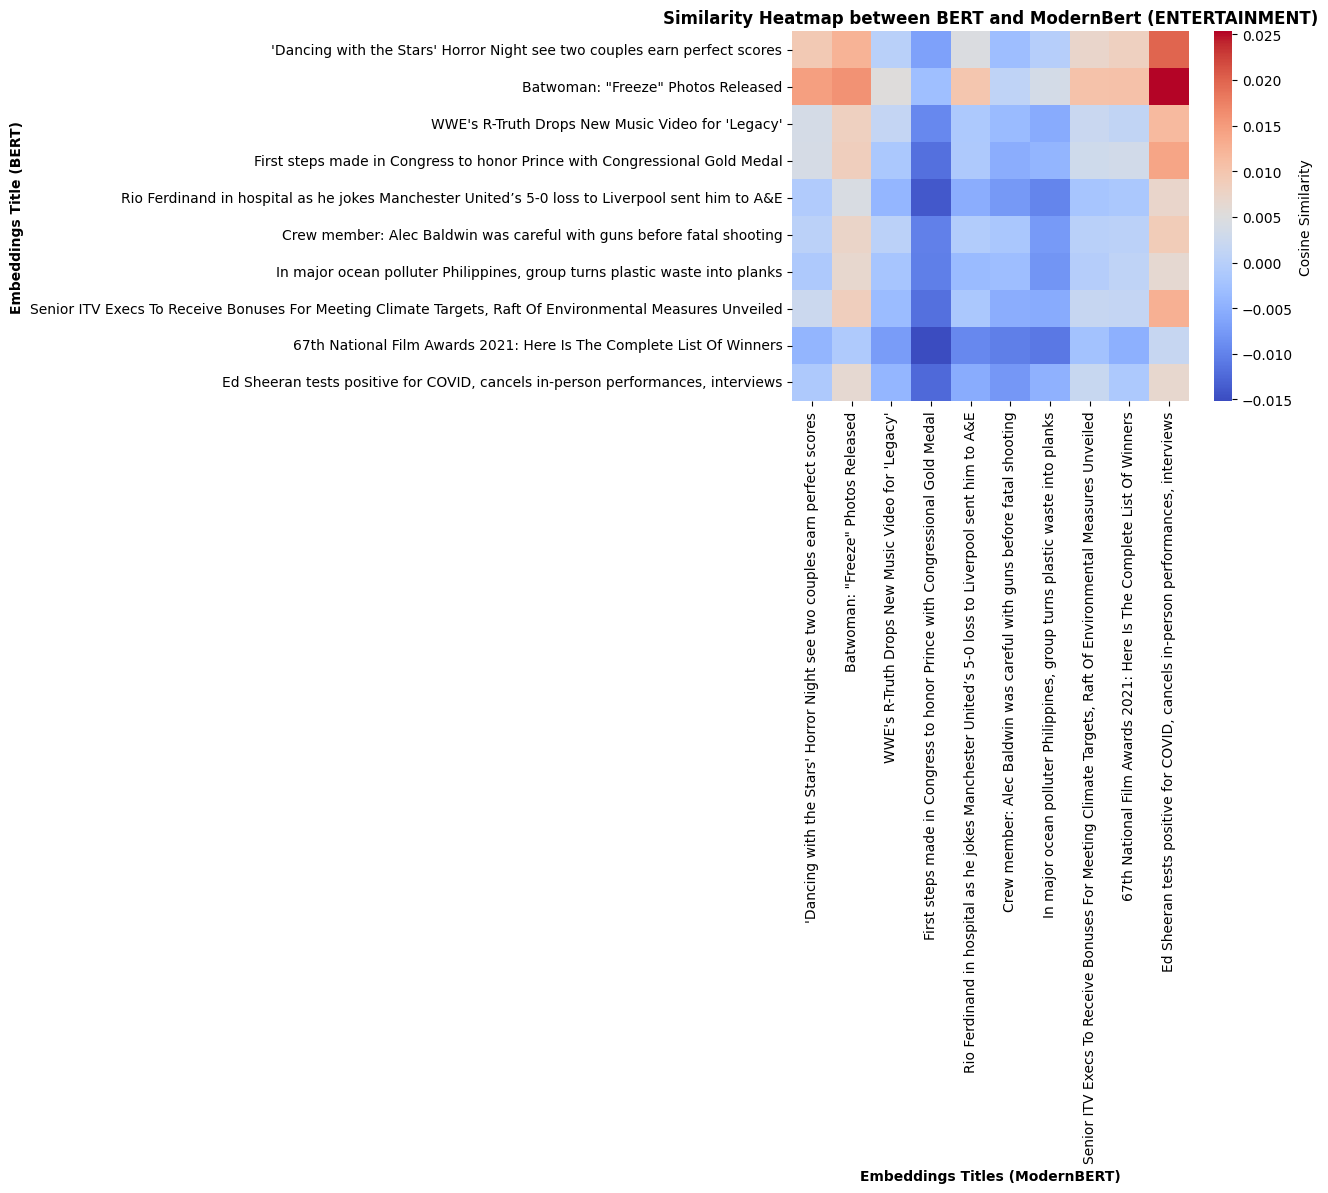

In [241]:
for c in categories:
    df = dataframe[dataframe['Category'] == c].copy()    
    titles = df['title'].value_counts().head(10).index
    df = df[df['title'].isin(titles)]
    df = df.drop_duplicates(subset=['title'], keep='first') 

    bert_embeddings_sample = df['embeddings_full_description']
    m_bert_embeddings_sample = df['m_bert_embeddings_full_description']

    bert_embeddings_sample = np.vstack(bert_embeddings_sample)
    m_bert_embeddings_sample = np.vstack(m_bert_embeddings_sample)

    similarity_matrix = cosine_similarity(bert_embeddings_sample, m_bert_embeddings_sample)
    labels = df['title']
    fig, ax = plt.subplots()
    sea.heatmap(similarity_matrix, annot=False, cmap='coolwarm', 
                xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Cosine Similarity'})
    plt.title(f'Similarity Heatmap between BERT and ModernBert ({c.upper()})', weight='bold')
    plt.xlabel('Embeddings Titles (ModernBERT)', weight='bold')
    plt.ylabel('Embeddings Title (BERT)', weight='bold')
    plt.show()


## Simple Classification

In [242]:
def generate_models_metrics(dataframe, col, embeddings_type):
    label_encoder = LabelEncoder()
    dataframe['label'] = label_encoder.fit_transform(dataframe['Category'])

    X_train, X_test, y_train, y_test = train_test_split(dataframe[col],
                                                        dataframe['label'],
                                                        test_size=0.3, random_state=42)
    X_train = [np.array(x) for x in X_train]
    X_test = [np.array(x) for x in X_test]

    y_train = np.array(y_train)
    y_test = np.array(y_test)

    clf = GaussianNB()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    r = recall_score(y_test, y_pred, average='macro', zero_division=0)
    p = precision_score(y_test, y_pred, average='macro', zero_division=0)

    print(f'{embeddings_type}')
    print(f'F1 = {f1:.3f}, Recall =  {r:.3f}, Precision = {p:.3f}')

generate_models_metrics(dataframe, 'embeddings_full_description', 'BERT')    
generate_models_metrics(dataframe, 'm_bert_embeddings_full_description', 'ModernBERT')

BERT
F1 = 0.114, Recall =  0.212, Precision = 0.149
ModernBERT
F1 = 0.214, Recall =  0.340, Precision = 0.232
